In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Path,PathPatch
from arnie.utils import *


def draw_contact(i, j, ax,ystart,size_multiple):
    size = size_multiple*(j - i)

    verts = [
       (i, ystart),   # P0
       (i, ystart+size),  # P1
       (j, ystart+size),  # P2
       (j, ystart),  # P3
    ]
    codes = [
        Path.MOVETO,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
    ]

    path = Path(verts, codes)

    patch = PathPatch(path, facecolor='none', lw=0.5)
    ax.add_patch(patch)

## INPUTS
seq = seqs[0]
struct = structs[0]
reacts = [shapes_incarnato_invivo[0], shapes_incarnato_invitro[0], shapes_zhang_invivo[0], shapes_zhang_invitro[0], shapes_pyle[0]]
react_labels = ["incarnato_invivo","incarnato_invitro", "zhang_invivo", "zhang_invitro", "pyle"]
num_white_space = 2 # increase if need more space at bottom for arc
figsize_x = 20
figsize_y = 3
arc_offset = 0 # increase if arc needs to move more down 
arc_height = 0.02 # decrease if want arc shorter


for i in range(num_white_space):
    reacts.append(np.zeros(len(seq)))
    react_labels.append("")

plt.figure(figsize=(figsize_x,figsize_y))

plt.imshow(reacts,cmap='gist_heat_r',aspect='auto')
g=plt.yticks(list(range(len(reacts))),react_labels)
g=plt.xticks(list(range(len(seq))),seq)
plt.gca().spines['bottom'].set_position(('data', len(reacts)-0.5-num_white_space))
bp_list = convert_dotbracket_to_bp_list(struct,allow_pseudoknots=True)
for i,j in bp_list:
    draw_contact(i,j,plt.gca(),len(reacts)-num_white_space-arc_offset,arc_height)

plt.colorbar(orientation='horizontal', label='reactivity')
plt.savefig('TEST.png',dpi=150, bbox_inches='tight')

NameError: name 'seqs' is not defined

<ipython-input-2-519d7af5ecc4>:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(figsize_x,figsize_y))


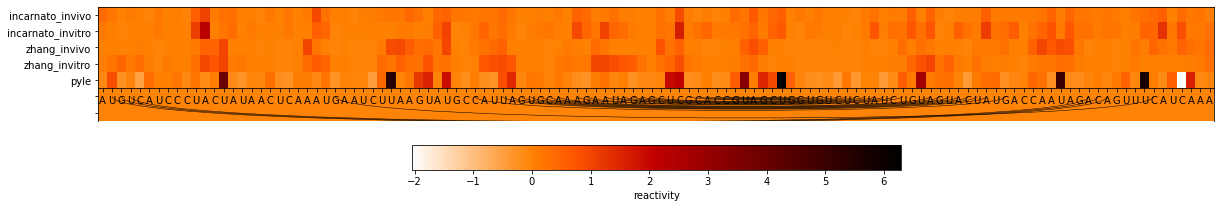

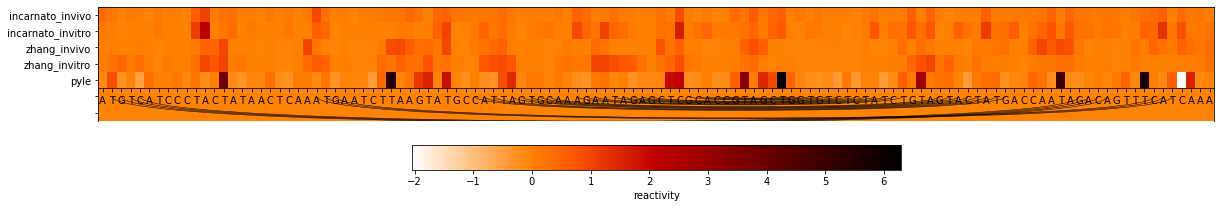

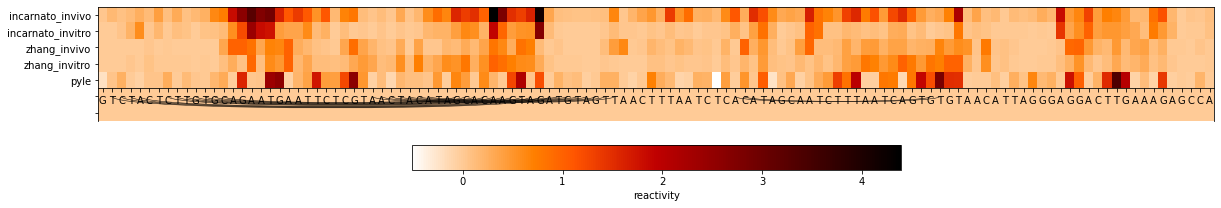

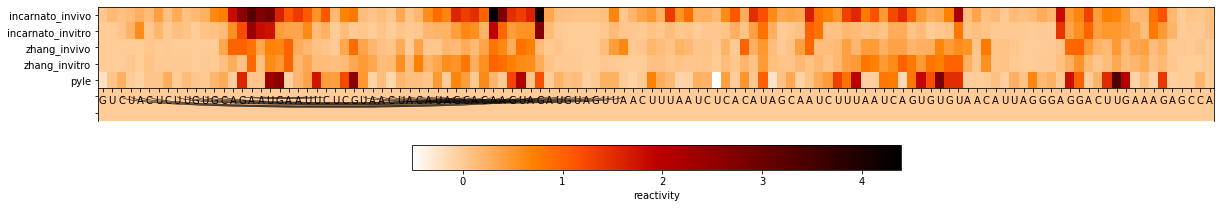

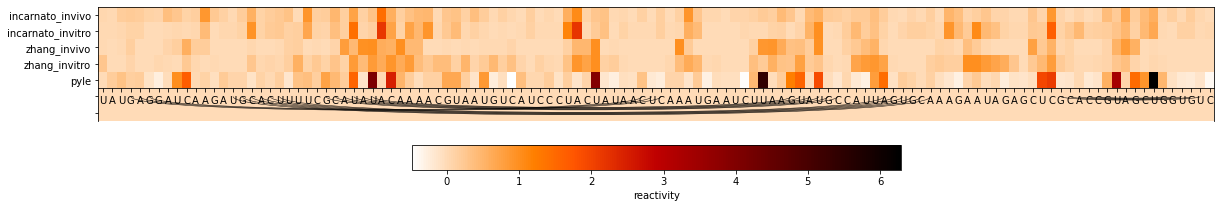

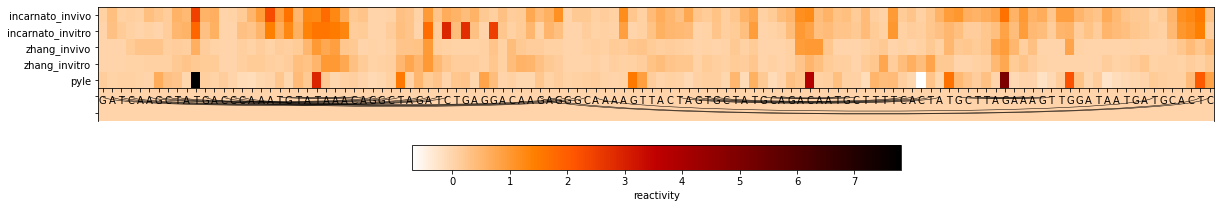

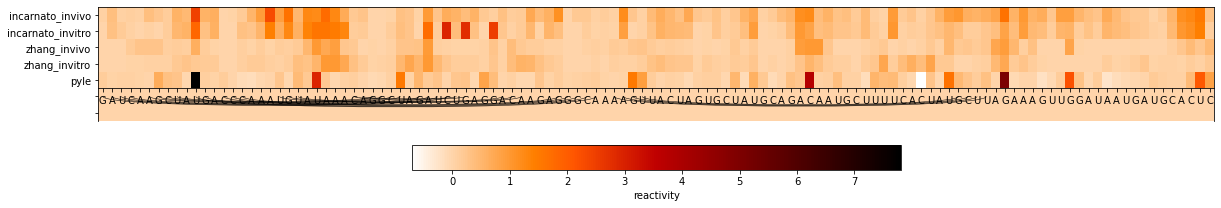

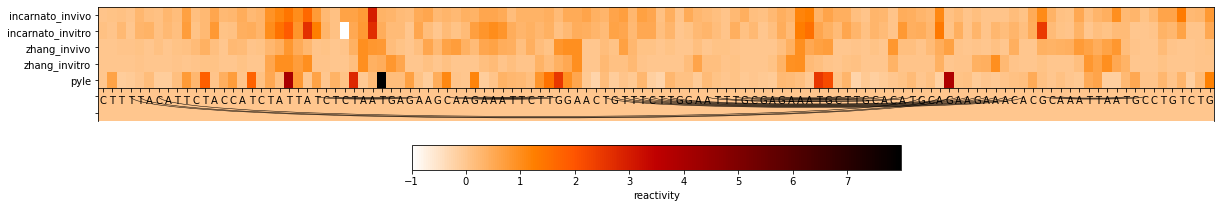

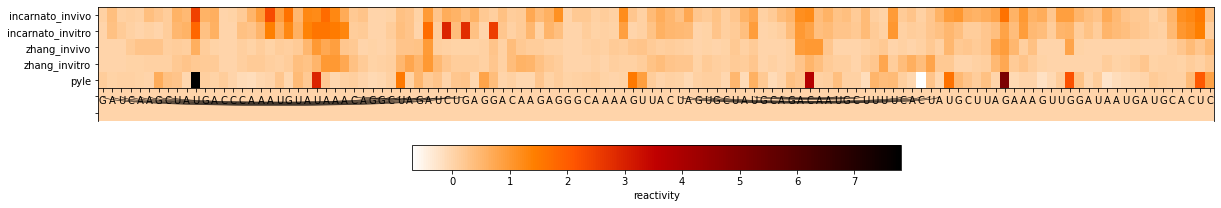

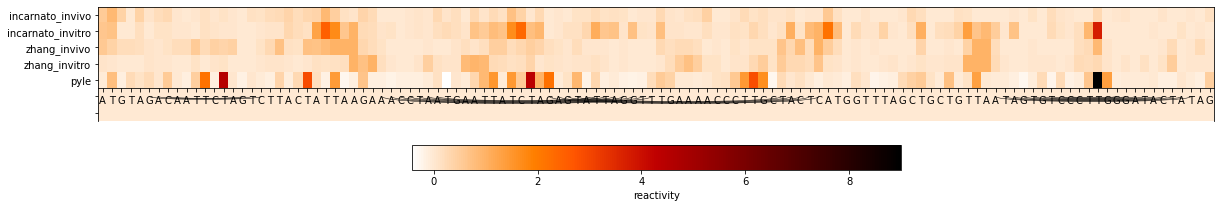

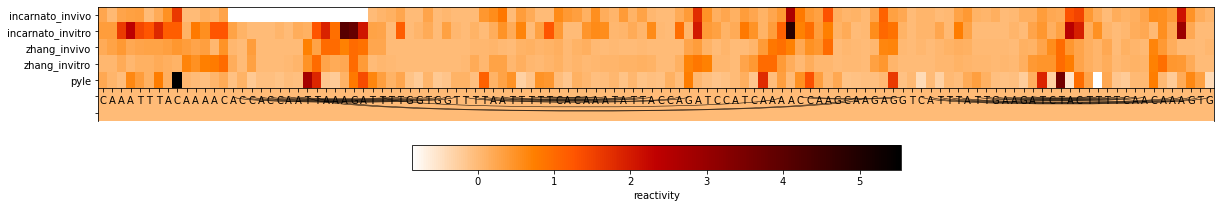

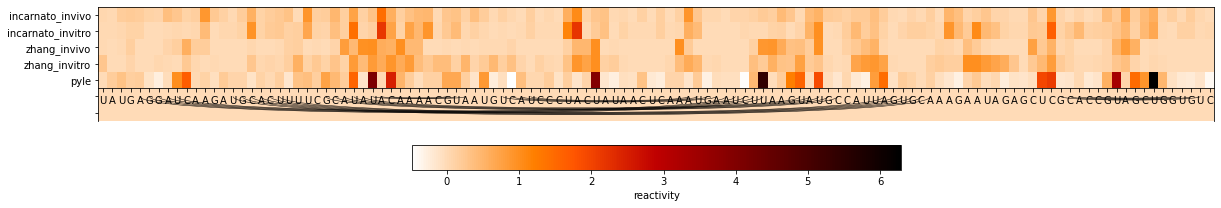

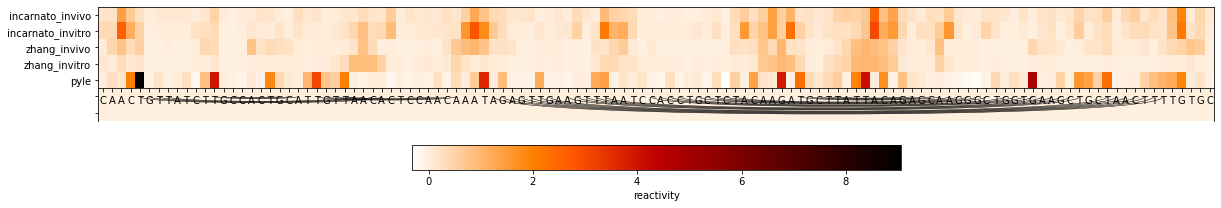

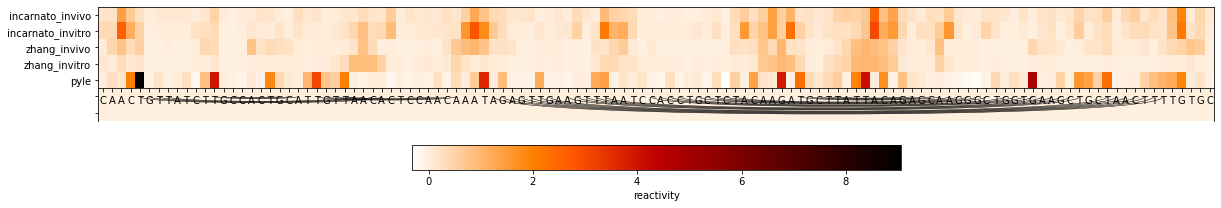

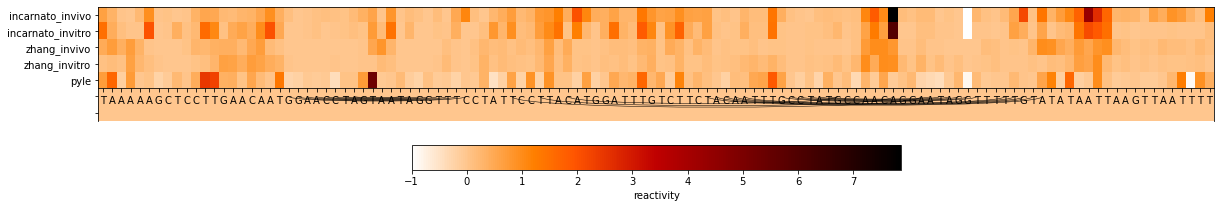

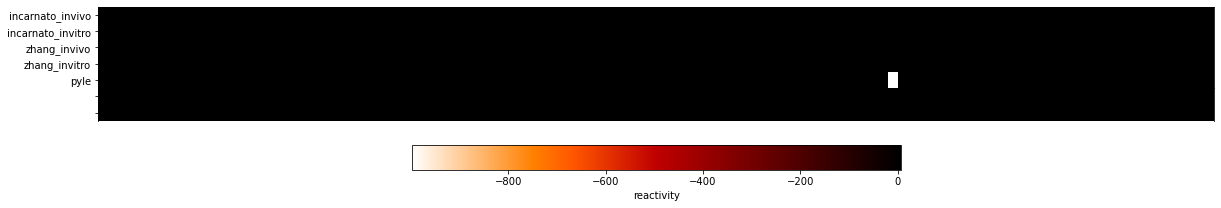

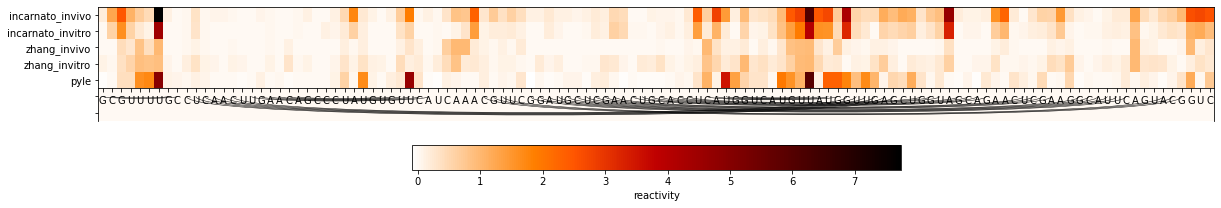

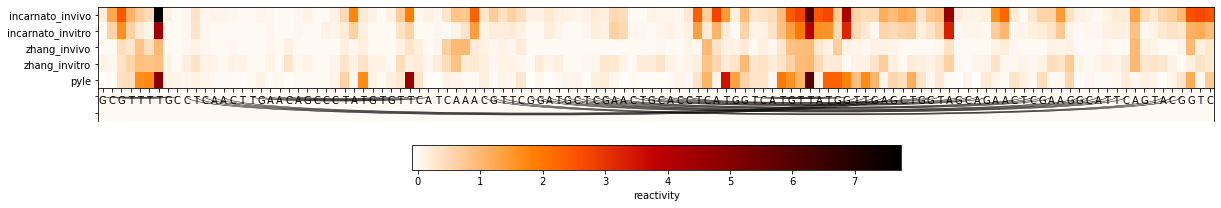

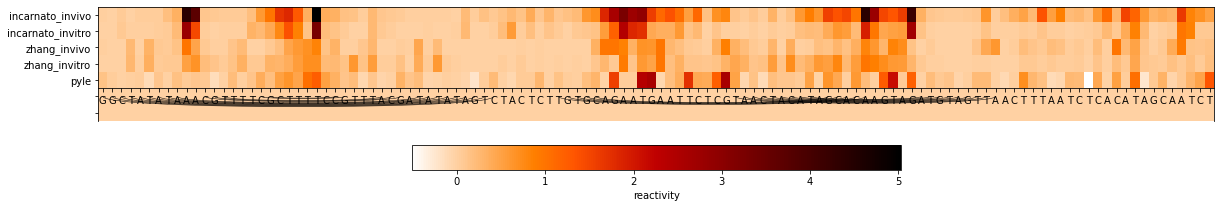

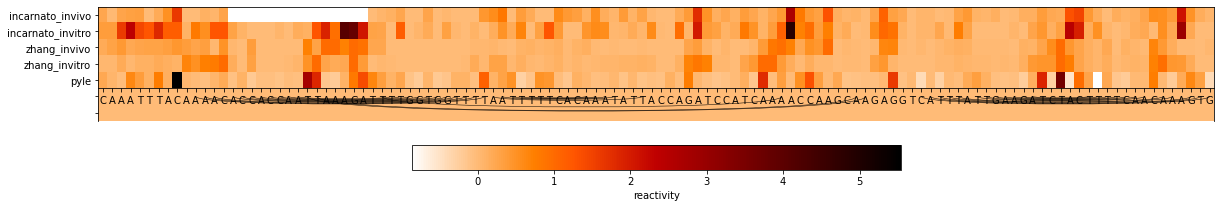

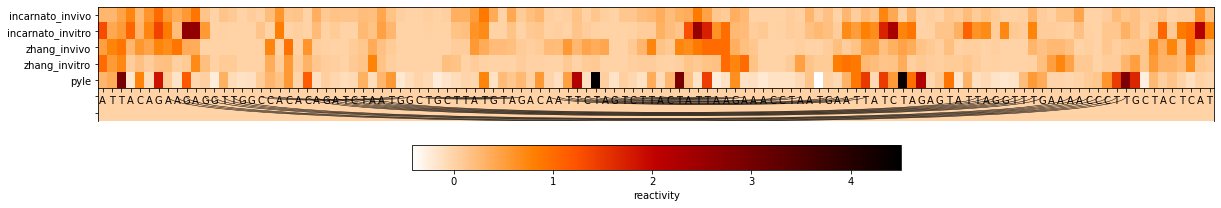

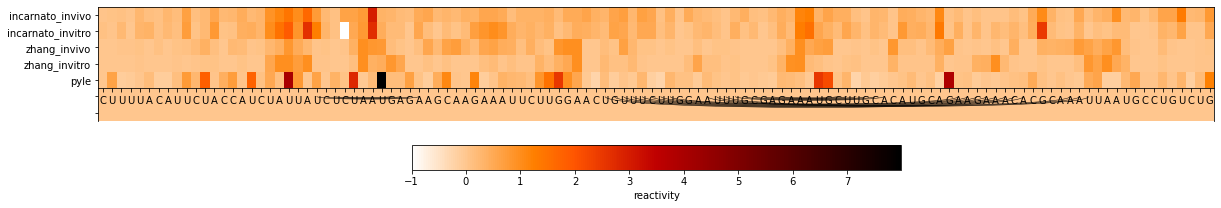

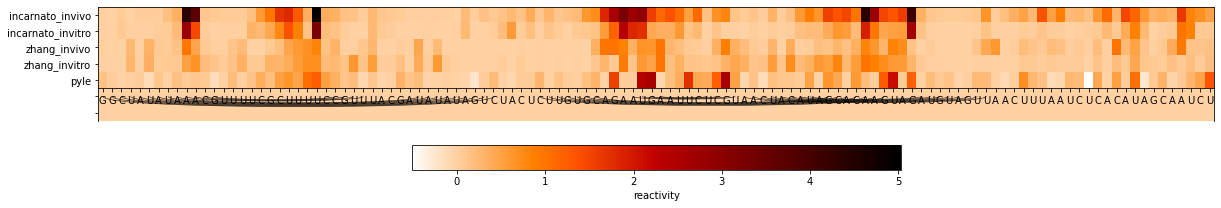

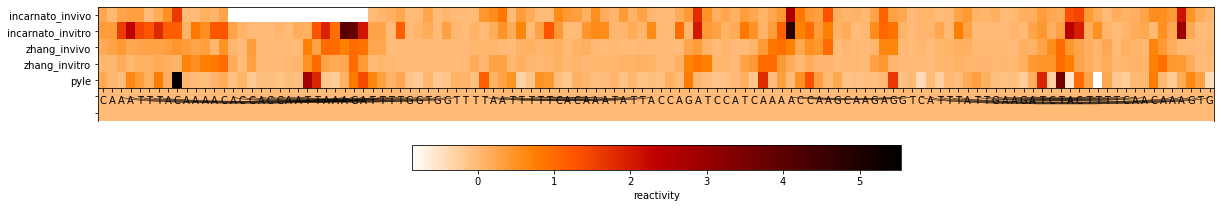

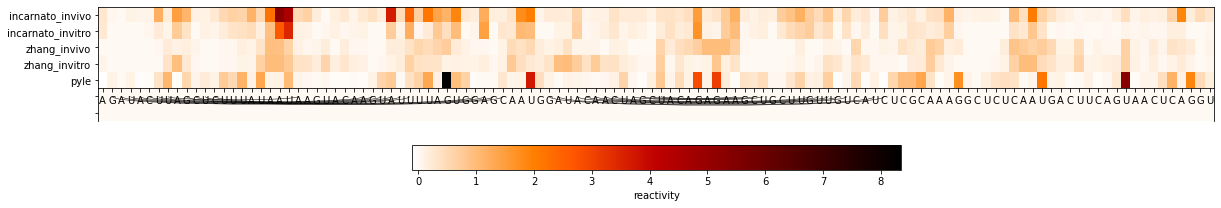

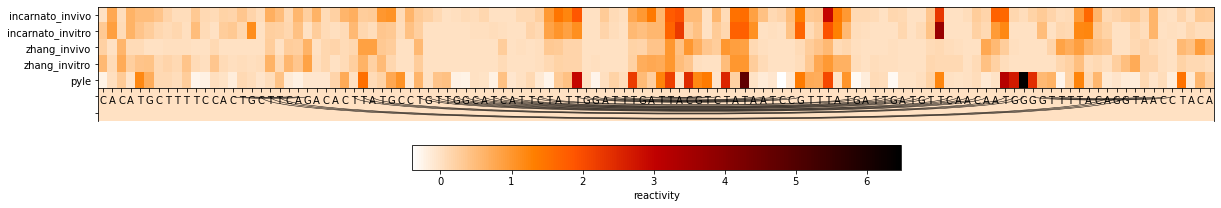

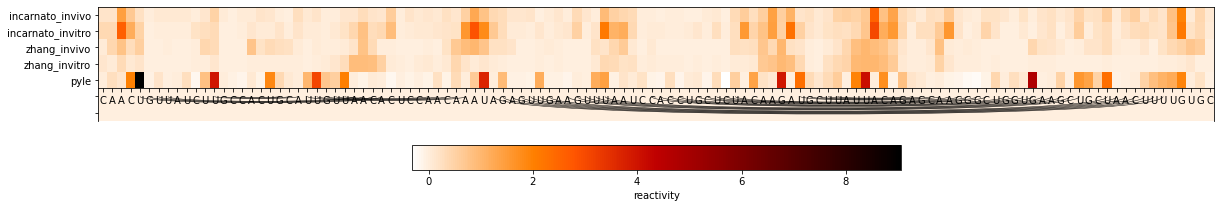

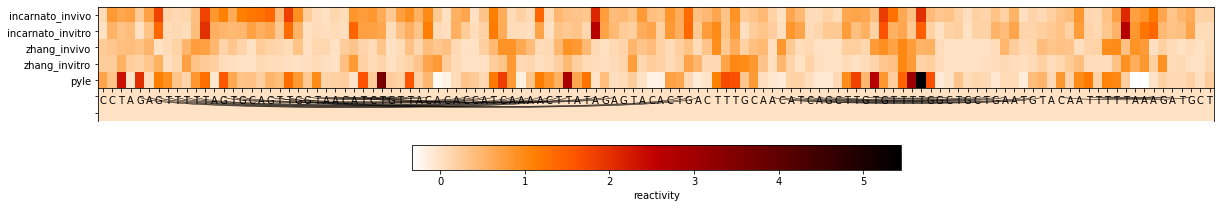

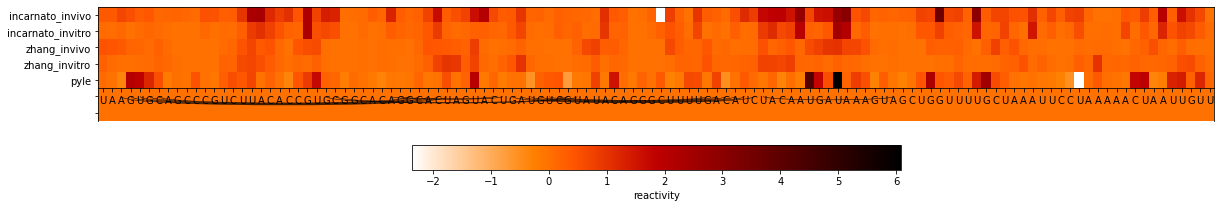

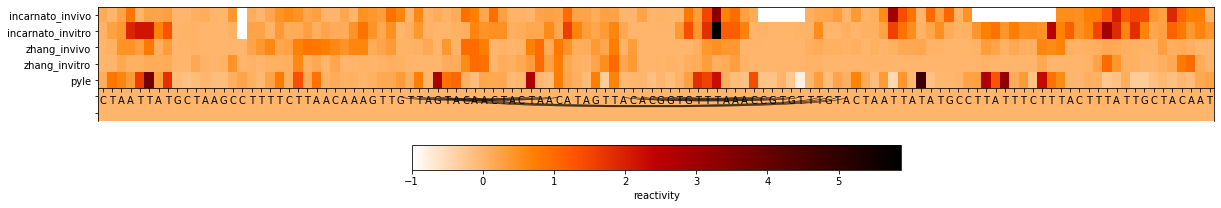

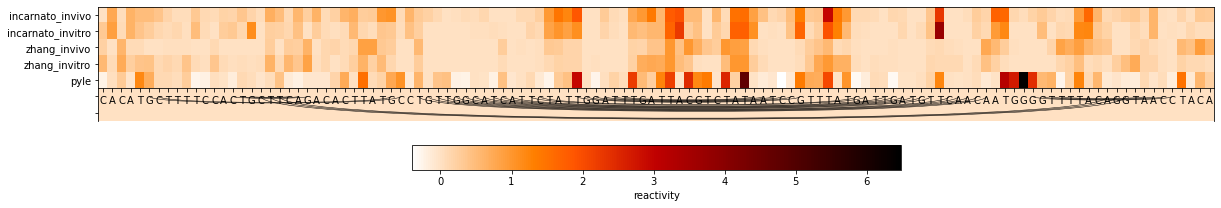

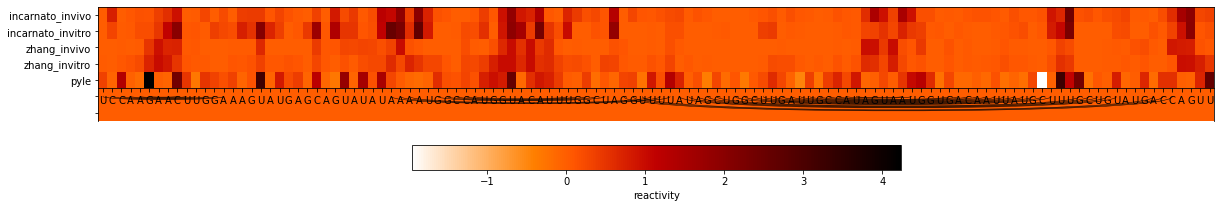

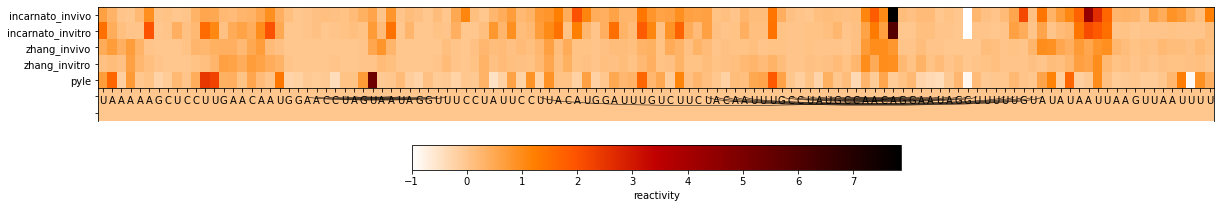

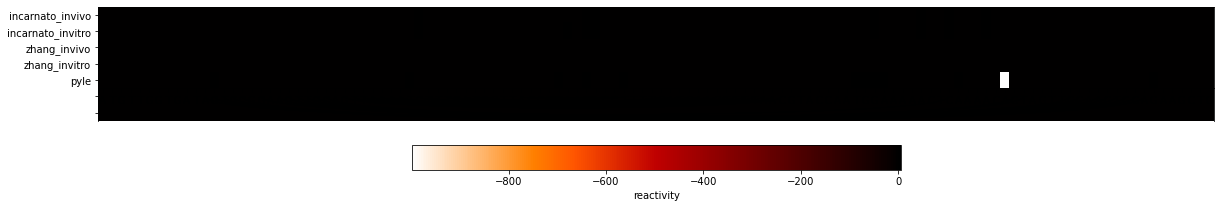

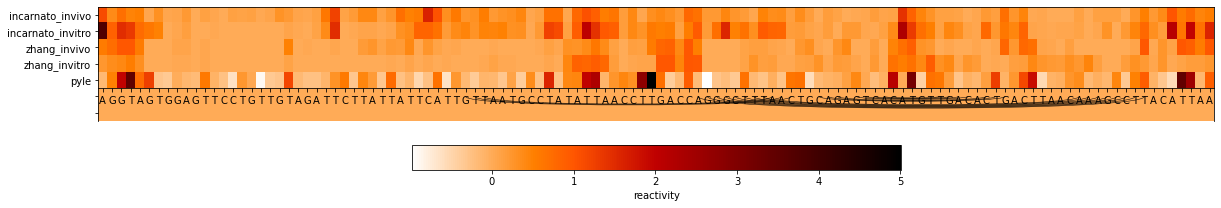

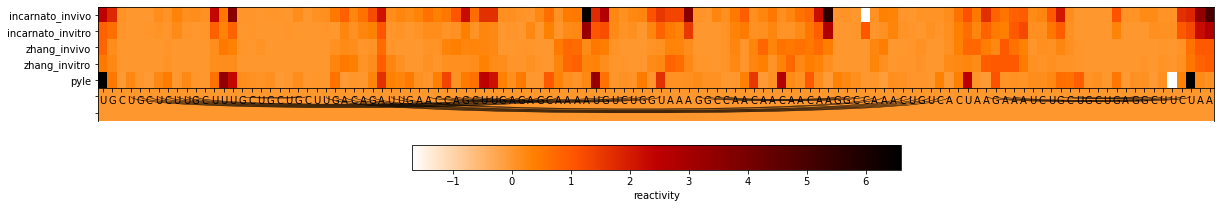

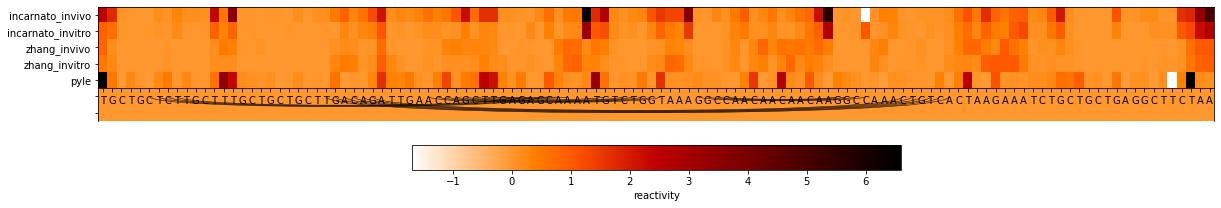

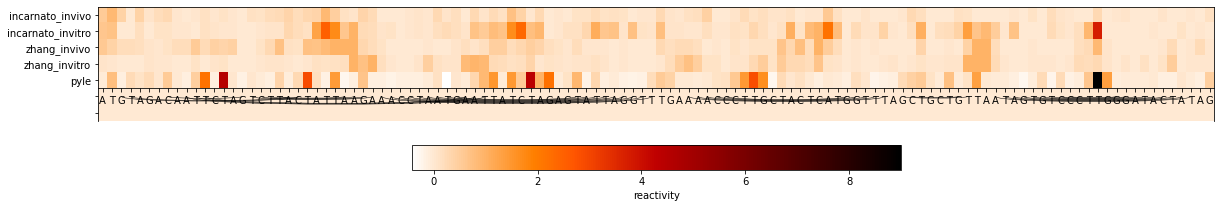

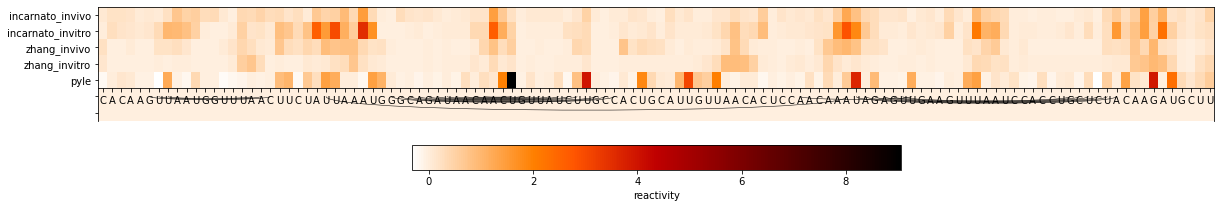

In [2]:
import pandas as pd

def get_shape_data(filename):
    shape = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            shape.append(line)
            
    for i in range(len(shape)):
        shape[i] = (-1) if shape[i] == 'nan' else float(shape[i])
        
    return shape

df = pd.read_csv('/home/gnye8/Desktop/PK_research/pipeline_results/analysis_output/top_pks.csv')
incarnato_invivo = get_shape_data('/home/gnye8/Desktop/PK_research/SSRP_work/shape_data/incarnato_invivo_reactivity-Copy1.csv')
incarnato_invitro = get_shape_data('/home/gnye8/Desktop/PK_research/SSRP_work/shape_data/incarnato_invitro_reactivity-Copy1.csv')
zhang_invivo = get_shape_data('/home/gnye8/Desktop/PK_research/SSRP_work/shape_data/zhang_invivo_reactivity-Copy1.csv')
zhang_invitro = get_shape_data('/home/gnye8/Desktop/PK_research/SSRP_work/shape_data/zhang_invitro_reactivity-Copy1.csv')
pyle = get_shape_data('/home/gnye8/Desktop/PK_research/SSRP_work/shape_data/pyle_reactivity-Copy1.csv')

starts = df['start'].to_list()
seqs = df['sequence'].to_list()
structs = df['structure'].to_list()

shapes_incarnato_invivo = []
for idx in starts: 
    shape_data = incarnato_invivo[idx:idx+120]
    shapes_incarnato_invivo.append(shape_data)

shapes_incarnato_invitro = []
for idx in starts: 
    shape_data = incarnato_invitro[idx:idx+120]
    shapes_incarnato_invitro.append(shape_data)
    
shapes_zhang_invivo = []
for idx in starts: 
    shape_data = zhang_invivo[idx:idx+120]
    shapes_zhang_invivo.append(shape_data)
    
    
shapes_zhang_invitro = []
for idx in starts: 
    shape_data = zhang_invitro[idx:idx+120]
    shapes_zhang_invitro.append(shape_data)
    
shapes_pyle = []
for idx in starts: 
    shape_data = pyle[idx:idx+120]
    shapes_pyle.append(shape_data)
    
    
for idx in range(0,39):
    seq = seqs[idx]
    struct = structs[idx]
    reacts = [shapes_incarnato_invivo[idx], shapes_incarnato_invitro[idx], shapes_zhang_invivo[idx], shapes_zhang_invitro[idx], shapes_pyle[idx]]
    react_labels = ["incarnato_invivo","incarnato_invitro", "zhang_invivo", "zhang_invitro", "pyle"]
    num_white_space = 2 # increase if need more space at bottom for arc
    figsize_x = 20
    figsize_y = 3
    arc_offset = 0 # increase if arc needs to move more down 
    arc_height = 0.02 # decrease if want arc shorter


    for i in range(num_white_space):
        reacts.append(np.zeros(len(seq)))
        react_labels.append("")

    plt.figure(figsize=(figsize_x,figsize_y))

    plt.imshow(reacts,cmap='gist_heat_r',aspect='auto')
    g=plt.yticks(list(range(len(reacts))),react_labels)
    g=plt.xticks(list(range(len(seq))),seq)
    plt.gca().spines['bottom'].set_position(('data', len(reacts)-0.5-num_white_space))
    bp_list = convert_dotbracket_to_bp_list(struct,allow_pseudoknots=True)
    for i,j in bp_list:
        draw_contact(i,j,plt.gca(),len(reacts)-num_white_space-arc_offset,arc_height)

    plt.colorbar(orientation='horizontal', label='reactivity')
    plt.savefig('{}.png'.format(idx), dpi=150, bbox_inches='tight')

In [7]:
import os

path = '/home/gnye8/Desktop/PK_research/pipeline_results/shape_analysis/'
programs = df['program'].to_list()

for idx in range(0,39):
    os.rename(path+str(idx)+'.png', path+programs[idx]+'_'+str(starts[idx])+'.png')